# Coursework: Age regression from brain MRI

Predicting the age of patient from a brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

The objective for the coursework is to implement different supervised learning approaches for age regression from brain MRI. We provided data from a total of 652 healthy subjects, that is split into different development sets and a held-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented all approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings.

#### Read the text descriptions and the provided code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and cross-validation of age regression approaches in part A, B and C. A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.

### Running on Colab or Azure

In [29]:
! pip install SimpleITK==1.2.2 
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
! unzip brainage-data.zip
! pip install scikit-learn

# data directory
data_dir = 'data/brain_age/'

--2020-02-23 21:24:51--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 900391705 (859M) [application/zip]
Saving to: ‘brainage-data.zip.2’

brainage-data.zip.2 100%[===================>] 858.68M  28.1MB/s    in 31s     

2020-02-23 21:25:22 (27.9 MB/s) - ‘brainage-data.zip.2’ saved [900391705/900391705]

Archive:  brainage-data.zip
replace data/brain_age/greymatter/wc1sub-CC110033_T1w.nii.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/brain_age/greymatter/wc1sub-CC110033_T1w.nii.gz  
  inflating: data/brain_age/greymatter/wc1sub-CC110037_T1w.nii.gz  
  inflating: data/brain_age/greymatter/wc1sub-CC110045_T1w.nii.gz  
  inflating: data/brain_age/greymatter/wc1sub-CC110056_T1w.nii.gz  
  inflating: data/brain_age/greymatter/wc1sub-CC110062_T1w.nii.gz  

### Running on DoC lab machines

In [0]:
# data directory
data_dir = '/vol/lab/course/416/data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [30]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [0]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image (used in part A)


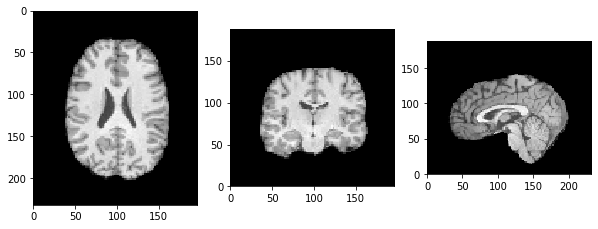

Brain mask (used in part A)


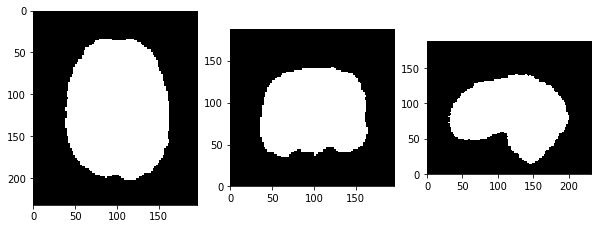

Spatially normalised grey matter maps (used in part B and C)


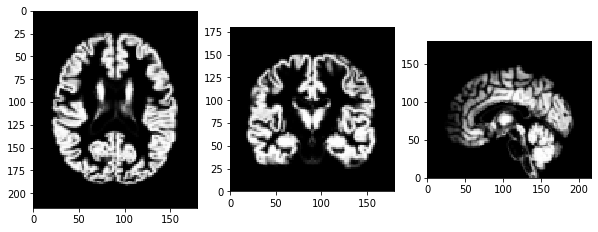

In [32]:
# Subject with index 0
def print_with_ID(id):
  ID = meta_data['subject_id'][id]
  age = meta_data['age'][id]

  # Image
  image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
  img = sitk.ReadImage(image_filename)

  # Mask
  mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
  msk = sitk.ReadImage(mask_filename)

  # Grey matter map
  gm_filename = data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz'
  gm = sitk.ReadImage(gm_filename)

  print('Imaging data of subject ' + ID + ' with age ' + str(age))

  print('\nMR Image (used in part A)')
  display_image(img, window=400, level=200)

  print('Brain mask (used in part A)')
  display_image(msk)

  print('Spatially normalised grey matter maps (used in part B and C)')
  display_image(gm)

print_with_ID(0)

## Part A: Volume-based regression using brain structure segmentation

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain structures include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* For part A, only the MR images and the brain masks should be used from the imaging data. The spatially normalised grey matter maps are used in part B and C only. If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is on your VM. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal.

#### Imports

In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn import metrics

#### Data Helpers

In [0]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [35]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla T4


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [0]:
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 100
learning_rate = 0.001
batch_size = 2
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [0]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_seg_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_seg_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [38]:
# LOAD ACTUAL TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# LOAD VALIDATION DATA AS TRAINING FOR QUICK DEBUGGING
#dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:00<00:00,  5.67it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


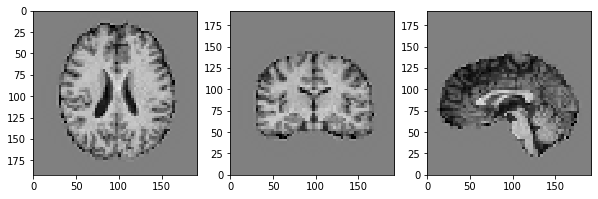

Segmentation


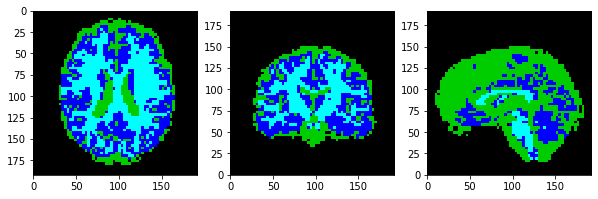

Mask


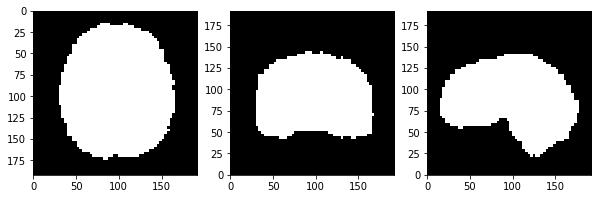

In [39]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [0]:
class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(4, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(8, 4, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(4, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        print("x len is:" + str(x.shape))
        return F.softmax(x, dim=1)

In [0]:
def outputSize(in_size, kernel_size, stride, padding):
        output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
        return(output)

In [0]:
########################################
# Better model:
# a) Use log_softmax instead of softmax
########################################

class ModSimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(ModSimpleNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(4, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(8, 4, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(4, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        # print("x intial shape is " + str(x.shape)) # 2, 1, 64, 64, 64        
        x = F.relu(self.conv1(x))
        # print("x after first is  " + str(x.shape)) # 2, 4, 64, 64, 64        
        x = F.relu(self.conv2(x))
        # print("x after second is " + str(x.shape)) # 2, 8, 64, 64, 64   
        x = F.relu(self.conv3(x))
        # print("x after third is " + str(x.shape)) # 2, 4, 64, 64, 64  
        x = self.conv4(x)
        # print("x after forth is " + str(x.shape)) # 2, 4, 64, 64, 64
        res =  F.log_softmax(x, dim=1)
        # print("x before ret is " + str(res.shape)) # 2, 4, 64, 64, 64
        return res

In [0]:
class InClassCNN(nn.Module):
    def __init__(self, num_classes):
        super(InClassCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 18, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=1, padding=1)
        self.conv2 = nn.Conv3d(18, 36, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=1, padding=0)
        self.conv3 = nn.Conv3d(36, 18, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=1, padding=1)        
        self.conv4 = nn.Conv3d(18, num_classes, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=1, padding=0)        

        #self.fc1 = nn.Linear(18 * 64 * 64 * 64, 32)
        #self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        #Computes the activation of the first convolution
        #print("x intial shape is " + str(x.shape)) # 2, 1, 64, 64, 64        
        x = F.relu(self.conv1(x))
        #print("x shape is " + str(x.shape)) # 2, 18, 64, 64, 64
        x = self.pool1(x)
        #print("x shape after pool is " + str(x.shape)) # 2, 18, 64, 64, 64
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        #Recall that the -1 infers this dimension from the other given dimension
        #x = x.view(-1, 18 * 32 * 32 * 32)
        #print("x shape after view " + str(x.shape)) # 2, 589824
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4608) to (1, 64)
        #x = F.relu(self.fc1(x))
        #print("x shape after relu " + str(x.shape)) # 2, 32
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        #x = self.fc2(x)
        #print("x shape after fc2 " + str(x.shape)) # 2, 4
        return F.log_softmax(x, dim=1)

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor precision, recall and Dice scores (or others).

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.832556 	Overall Dice Score: 0.37677750454399656
Dice score for...
CSF: 0.0	GM: 0.7933899182745346	WM: 0.0	
--------------------------------------------------
Overall Dice score: 0.7528840215735518
+ VALIDATE 	Epoch: 1 	Loss: 0.806343 	Overall Dice Score: 0.3357149601838154
Dice score for...
CSF: 0.0	GM: 0.8312896186220513	WM: 0.0	


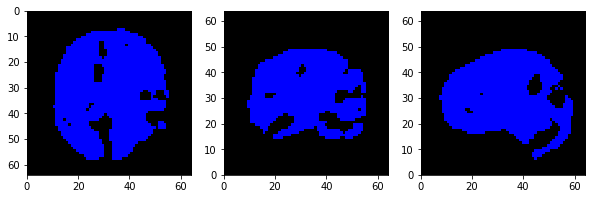

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.311746 	Overall Dice Score: 0.4951207516889705
Dice score for...
CSF: 0.21520078129488138	GM: 0.9094084335102324	WM: 5.588309257034284e-05	
+ TRAINING 	Epoch: 3 	Loss: 0.238510 	Overall Dice Score: 0.6219878750827857
Dice score for...
CSF: 0.6616728292745123	GM: 0.6073183826869863	WM: 0.6627813504823151	
+ TRAINING 	Epoch: 4 	Loss: 0.219094 	Overall Dice Score: 0.6445764986170825
Dice score for...
CSF: 0.5714019214625502	GM: 0.6438523130004312	WM: 0.7982590205329259	
+ TRAINING 	Epoch: 5 	Loss: 0.202050 	Overall Dice Score: 0.6762488177004604
Dice score for...
CSF: 0.6728130208148647	GM: 0.6759577748784249	WM: 0.7426952702272582	
+ TRAINING 	Epoch: 6 	Loss: 0.191168 	Overall Dice Score: 0.636589452932479
Dice score for...
CSF: 0.6371556968603833	GM: 0.5436893203883496	WM: 0.7623886588884707	
+ TRAINING 	Epoch: 7 	Loss: 0.189391 	Overall Dice Score: 0.6908180300500836
Dice score for...
CSF: 0.69876733436055

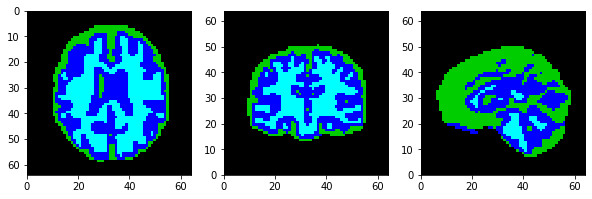

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.170766 	Overall Dice Score: 0.7016467607672819
Dice score for...
CSF: 0.5597983381570348	GM: 0.7967064418123376	WM: 0.7508433734939758	
+ TRAINING 	Epoch: 12 	Loss: 0.230108 	Overall Dice Score: 0.6625697267656235
Dice score for...
CSF: 0.5734449621995785	GM: 0.6856506907313769	WM: 0.8094913151364764	
+ TRAINING 	Epoch: 13 	Loss: 0.195137 	Overall Dice Score: 0.7051963588252537
Dice score for...
CSF: 0.7269820971867007	GM: 0.6676150871817319	WM: 0.7771374685666387	
+ TRAINING 	Epoch: 14 	Loss: 0.193781 	Overall Dice Score: 0.6910591110783035
Dice score for...
CSF: 0.7528820675178085	GM: 0.6190905309857202	WM: 0.7998679590673109	
+ TRAINING 	Epoch: 15 	Loss: 0.189433 	Overall Dice Score: 0.7235858116724657
Dice score for...
CSF: 0.6485257907696194	GM: 0.7800167620158145	WM: 0.7481207930646133	
+ TRAINING 	Epoch: 16 	Loss: 0.186109 	Overall Dice Score: 0.7099861166203887
Dice score for...
CSF: 0.68811766223

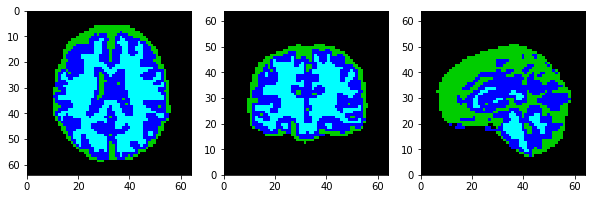

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.157588 	Overall Dice Score: 0.7365697653526897
Dice score for...
CSF: 0.7049476345250992	GM: 0.7000611596661865	WM: 0.8588886767233149	
+ TRAINING 	Epoch: 22 	Loss: 0.190124 	Overall Dice Score: 0.7138790552146249
Dice score for...
CSF: 0.632440708683561	GM: 0.7239762537214982	WM: 0.7977631730658364	
+ TRAINING 	Epoch: 23 	Loss: 0.170616 	Overall Dice Score: 0.7370518263208776
Dice score for...
CSF: 0.669346609357123	GM: 0.762671401795403	WM: 0.7875143843498275	
+ TRAINING 	Epoch: 24 	Loss: 0.146581 	Overall Dice Score: 0.7456959706959707
Dice score for...
CSF: 0.7094110884673669	GM: 0.7581181634262594	WM: 0.8092303478499041	
+ TRAINING 	Epoch: 25 	Loss: 0.149021 	Overall Dice Score: 0.7454417301949438
Dice score for...
CSF: 0.6739028726490127	GM: 0.7672437997192326	WM: 0.8301435406698565	
+ TRAINING 	Epoch: 26 	Loss: 0.146685 	Overall Dice Score: 0.7394138042098483
Dice score for...
CSF: 0.77495417430428

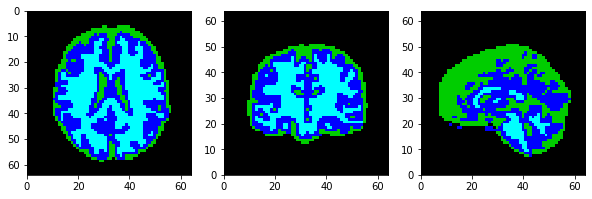

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.161322 	Overall Dice Score: 0.748204832538393
Dice score for...
CSF: 0.5888283802707328	GM: 0.82485811791768	WM: 0.8272436012815436	
+ TRAINING 	Epoch: 32 	Loss: 0.138404 	Overall Dice Score: 0.7608697711876451
Dice score for...
CSF: 0.7191609788579989	GM: 0.7863405819421343	WM: 0.8056288478452067	
+ TRAINING 	Epoch: 33 	Loss: 0.168194 	Overall Dice Score: 0.7484798608209177
Dice score for...
CSF: 0.6192380282140686	GM: 0.795629235906657	WM: 0.8095854549638963	
+ TRAINING 	Epoch: 34 	Loss: 0.168332 	Overall Dice Score: 0.7727193819980904
Dice score for...
CSF: 0.73526018969495	GM: 0.788313085294862	WM: 0.8057073897920068	
+ TRAINING 	Epoch: 35 	Loss: 0.172649 	Overall Dice Score: 0.7457350301579858
Dice score for...
CSF: 0.7901208015198767	GM: 0.7065600433721876	WM: 0.8228531815949858	
+ TRAINING 	Epoch: 36 	Loss: 0.143349 	Overall Dice Score: 0.7336458514188707
Dice score for...
CSF: 0.8627258872196821	G

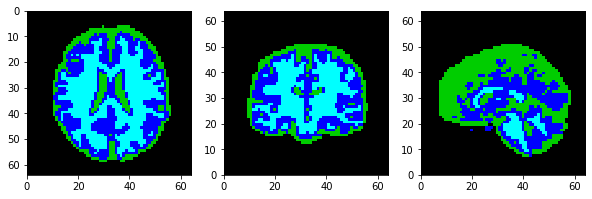

--------------------------------------------------
+ TRAINING 	Epoch: 41 	Loss: 0.158667 	Overall Dice Score: 0.7528613540174234
Dice score for...
CSF: 0.6887688487237911	GM: 0.7852637314277332	WM: 0.814326561324304	
+ TRAINING 	Epoch: 42 	Loss: 0.186616 	Overall Dice Score: 0.7551800926089569
Dice score for...
CSF: 0.7728389433427044	GM: 0.7516887417218543	WM: 0.7752972457733407	
+ TRAINING 	Epoch: 43 	Loss: 0.131875 	Overall Dice Score: 0.7900041619166531
Dice score for...
CSF: 0.8139712146348025	GM: 0.8126506356594851	WM: 0.8220511808433655	
+ TRAINING 	Epoch: 44 	Loss: 0.156778 	Overall Dice Score: 0.7741712598734317
Dice score for...
CSF: 0.7897969807391984	GM: 0.7818507382006149	WM: 0.7855320506006166	
+ TRAINING 	Epoch: 45 	Loss: 0.156494 	Overall Dice Score: 0.7522677249383045
Dice score for...
CSF: 0.8006664103549916	GM: 0.7073494967398873	WM: 0.7947949822130688	
+ TRAINING 	Epoch: 46 	Loss: 0.158504 	Overall Dice Score: 0.7613504640700361
Dice score for...
CSF: 0.783474989549

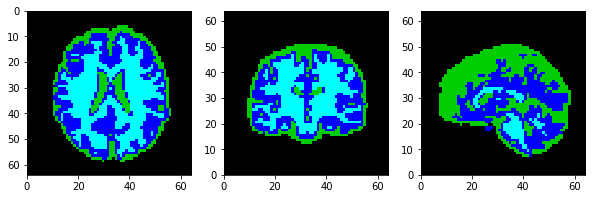

--------------------------------------------------

Finished TRAINING.


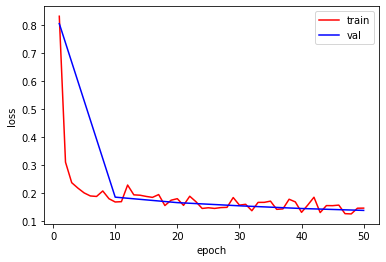

In [68]:
#img has size (2, 1, 64, 64, 64) = (B- batch size, N - number of channels, W, H, D)
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed
matters={
  
}
model = ModSimpleNet3D(num_classes=num_classes).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
num_epochs = 50

def get_dice_score(img, ref, tissue_class):
  check_ref = ref.cpu().squeeze().numpy().astype(np.uint8)
  img_arr = img.cpu().squeeze().numpy().astype(np.uint8)
  
  check_ref[check_ref != tissue_class] = 0
  img_arr[check_ref != tissue_class] = 0

  dice_prd = sitk.GetImageFromArray(img_arr)
  dice_seg = sitk.GetImageFromArray(check_ref)
  overlap_filter = sitk.LabelOverlapMeasuresImageFilter()
  overlap_filter.Execute(dice_prd, dice_seg)
  dice_score = overlap_filter.GetDiceCoefficient()
  return dice_score


print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        #print("img size is" + str(img.shape))
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1) # (2, 4, 262144) - (N, C=no_classes, )
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        #print("seg is" + str(seg_flat.squeeze(1).shape) + "prd is: " + str(prd_flat.shape))

        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))  # seg_flat.squeeze(1) - (1, 262144)
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())
    prd = torch.argmax(prd, dim=1)

    # Getting the dice scores for overall
    dice_prd = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
    dice_seg = sitk.GetImageFromArray(seg.cpu().squeeze().numpy().astype(np.uint8))
    overlap_filter = sitk.LabelOverlapMeasuresImageFilter()
    overlap_filter.Execute(dice_prd, dice_seg)
    overall_dice_score = overlap_filter.GetDiceCoefficient()

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f} \tOverall Dice Score: {}'.format(epoch, loss.item(), overall_dice_score))
    print('Dice score for...')
    for matter, matter_num in matters.items():
         print('{}: {}\t'.format(matter, get_dice_score(prd, seg, matter_num)), end = '')
    print()
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
                
                loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
                sum_pts += seg_flat.size(2)
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))

        # Getting the dice scores for overall
        dice_prd = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        dice_seg = sitk.GetImageFromArray(seg.cpu().squeeze().numpy().astype(np.uint8))
        overlap_filter = sitk.LabelOverlapMeasuresImageFilter()
        overlap_filter.Execute(dice_prd, dice_seg)
        overall_dice_score = overlap_filter.GetDiceCoefficient()
        
        
        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        
        # ==== Report training loss and accuracy ======
        # y_pred and loss can be either np.array, or torch.tensor (see later). If tensor, make it np.array.
        #y_pred_numpy = y_pred if type(y_pred) is np.ndarray else y_pred.detach().numpy()
        #y_pred_lbls = np.argmax(y_pred_numpy, axis=1) # y_pred is soft/probability. Make it a hard one-hot label.
        #y_real_lbls = np.argmax(y_real, axis=1)
        
        #acc_train = np.mean(y_pred_lbls == y_real_lbls) * 100. # percentage
        
        #loss_numpy = loss if type(loss) is type(float) else loss.item()
        #print("[iter:", t, "]: Training Loss: {0:.2f}".format(loss), "\t Accuracy: {0:.2f}".format(acc_train))


        print('--------------------------------------------------')
        print('Overall Dice score: {}'.format(dice_scores))
        #getting dice scores for individual matters
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f} \tOverall Dice Score: {}'.format(epoch, loss_val, overall_dice_score))
        print('Dice score for...')
        for matter, matter_num in matters.items():
          print('{}: {}\t'.format(matter, get_dice_score(prd, seg, matter_num)), end = '')
        print()
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [69]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [01:30<00:00,  5.72it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


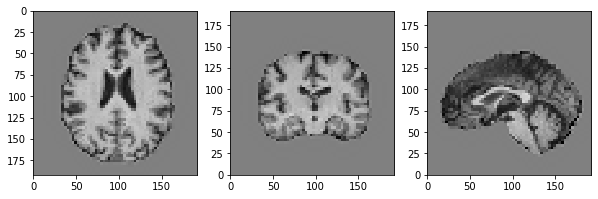

Segmentation


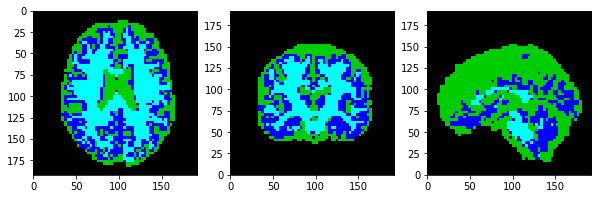

Mask


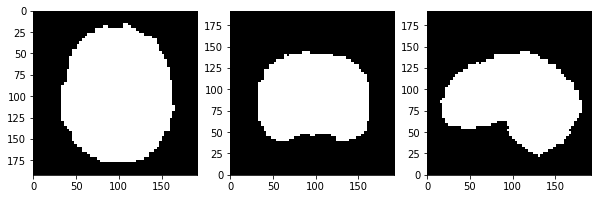

In [70]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly others) to evaluate the segmentation performance.**

START TESTING...


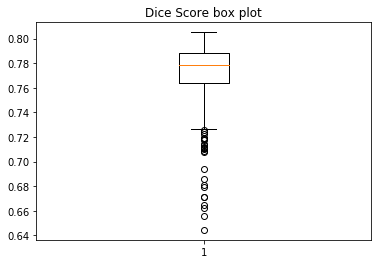

+ TESTING 	Loss: 0.150521, 	Overall Dice Score: 0.7721133589818056
Dice score for...
CSF: 0.7065462918202391	GM: 0.826862473069832	WM: 0.8116082660126438	


Reference segmentation


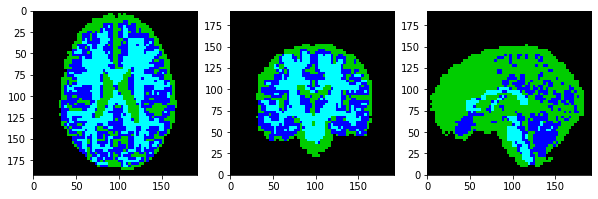

Predicted segmentation


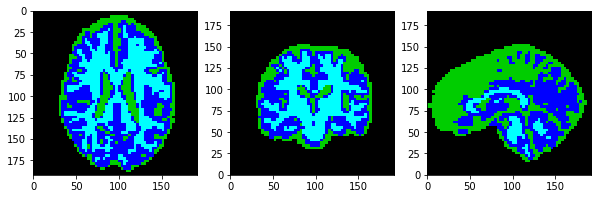


Finished TESTING.


In [74]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = ModSimpleNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
dice_scores = []
dice_scores_by_parts = {
  'CSF' : [],
  'GM' : [],
  'WM' : []
}
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
        sum_pts += seg_flat.size(2)        
        
        prd = torch.argmax(prd, dim=1)

        dice_prd = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        dice_seg = sitk.GetImageFromArray(seg.cpu().squeeze().numpy().astype(np.uint8))
        overlap_filter = sitk.LabelOverlapMeasuresImageFilter()
        overlap_filter.Execute(dice_prd, dice_seg)
        overall_dice_score = overlap_filter.GetDiceCoefficient()
        dice_scores.append(overall_dice_score)

        for matter, matter_num in matters.items():
            dice_scores_by_parts[matter].append(get_dice_score(prd, seg, matter_num))
        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        

loss_test /= sum_pts
fig1, ax1 = plt.subplots()
ax1.set_title('Dice Score box plot')
ax1.boxplot(dice_scores)
plt.show()

print('+ TESTING \tLoss: {:.6f}, \tOverall Dice Score: {}'.format(loss_test, np.mean(dice_scores)))
print('Dice score for...')
for matter, scores in dice_scores_by_parts.items():
      print('{}: {}\t'.format(matter, np.mean(scores)), end = '')
print()

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [0]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
#seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        img_array = sitk.GetArrayFromImage(seg)
        GM = 0
        WM = 0
        CSF = 0
        for cell in img_array.flat:
            if cell == 1:
                CSF += 1
            elif cell == 2:
                GM += 1
            elif cell == 3:
                WM += 1
        vols[0][idx] = CSF
        vols[1][idx] = GM
        vols[2][idx] = WM

Plot features versus age.

In [0]:
plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

In [0]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    CSF = vols[0][idx]
    GM = vols[1][idx]
    WM = vols[2][idx]
    nonBackground = CSF + GM + WM
    vols_normalised[0][idx] = CSF / nonBackground
    vols_normalised[1][idx] = GM / nonBackground
    vols_normalised[2][idx] = WM / nonBackground    

Plot normalised features versus age.

In [0]:
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

Final data for age regression

In [0]:
X = vols_normalised.T
y = meta_data_reg_train['age'].values.reshape(-1,1)

print(X.shape)
print(y.shape)

### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

Error calculation and plotting

In [0]:
def plot(y, predicted):
  print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
  print('r2 score: {0}'.format(r2_score(y,predicted)))

  fig, ax = plt.subplots()
  ax.scatter(y, predicted, marker='.')
  ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
  ax.set_xlabel('Real Age')
  ax.set_ylabel('Predicted Age')
  plt.show()

In [0]:
########################################
# ADD YOUR CODE HERE
########################################

from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import statistics
from sklearn import svm

kf = KFold(n_splits=2)

# NN regression model
est = make_pipeline(MLPRegressor(hidden_layer_sizes=(150, 50, 50, 50 ,10),
                                  learning_rate_init=0.005,
                                  early_stopping=True))
nn_err = 0
for train, test in kf.split(X):
  X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
  y_train = np.reshape(y_train, (1, -1))[0]
  y_test = np.reshape(y_test, (1, -1))[0]

  est.fit(X_train, y_train)
  nn_y_pred = est.predict(X_test)
  nn_err += mean_absolute_error(nn_y_pred, y_test)
  plot(y_test, nn_y_pred)

nn_mean_age_err = nn_err / 2
print("mean age error using Neural Network regression is {}".format(nn_mean_age_err))

In [0]:
# SVR regression model

kf = KFold(n_splits=2)

clf = svm.SVR()
svr_err = 0

for train, test in kf.split(X):
  X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
  y_train = np.reshape(y_train, (1, -1))[0]
  y_test = np.reshape(y_test, (1, -1))[0]
  
  clf.fit(X_train, y_train)
  svr_y_pred = clf.predict(X_test)
  svr_err += mean_absolute_error(svr_y_pred, y_test)
  plot(y_test, svr_y_pred)

svr_mean_age_err = svr_err /2
print("mean age error using support vector regression is {}".format(svr_mean_age_err))

In [0]:
#decision tree with adaboost regression model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

kf = KFold(n_splits=2)
rng = np.random.RandomState(1)
# dt_reg = DecisionTreeRegressor(max_depth=4)
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)
ensemble_err = 0

for train, test in kf.split(X):
  X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
  y_train = np.reshape(y_train, (1, -1))[0]
  y_test = np.reshape(y_test, (1, -1))[0]
  
  # dt_reg.fit(X_train, y_train)
  ada_reg.fit(X_train, y_train)
  # dt_y_pred = dt_reg.predict(X_test)
  ada_y_pred = ada_reg.predict(X_test)
  ensemble_err += mean_absolute_error(ada_y_pred, y_test)
  plot(y_test, ada_y_pred)

ada_mean_age_err = ensemble_err /2
print("mean age error using decision tree with adaboost regression is {}".format(ada_mean_age_err))

## Part B: PCA-based regression using grey matter maps

The second approach will make use of grey matter maps that have been already extracted from the MRI scans and aligned to a common reference space to obtain spatially normalised maps. For this, we have used an advanced, state-of-the-art neuroimaging toolkit, called SPM12. The reference space corresponds to the commonly used MNI atlas as seen in the lecture on image segmentation.

Because these grey matter maps are spatially normalised (ie., registered), voxel locations across images from different subjects roughly correspond to the same anatomical locations. This means that each voxel location in the grey matter maps can be treated as an individual feature. Because those maps are quite large at their full resolution there would be a very large number of features to deal with (more than 850,000). A dimensionality reduction may need to be performed before training a suitable regressor on the low-dimensional feature representation. We will use Principal Component Analysis (PCA) to do the dimensionality reduction. It might also be beneficial to apply some pre-processing (downsampling, smoothing, etc.) before running PCA, which should be explored. The implemented pipeline should be evaluated using two-fold cross-validation using the same data splits as in part A for the 500 subjects, so the two different approaches can be directly compared in terms average age prediction accuracy.

*Note:* For part B, only the spatially normalised grey matter maps should be used.

### TASK B-1: Pre-processing

Before running PCA to reduce the dimensionality of the feature space for grey matter maps, it might be beneficial to run some pre-processing on the maps. In voxel-based analysis where each voxel location is a feature, it is common to apply some smoothing beforehand. This is to reduce noise and to compensate for errors of the spatial normalisation.

Because the maps are quite large, it might also be worthwile to explore whether downsampling could be performed even before PCA. This would further reduce the dimensionality, and might be even needed in the case where PCA on the orignial resolution runs into memory issues. You may want to consider other ways of pre-processing and you can find insipiration in the notebook on medical image computing `02-Intro-Medical-Image-Computing.ipynb`.

Implement a function that performs suitable pre-processing on each grey matter map.

*Hint:* You may want to save the pre-processed maps using `sitk.WriteImage` to avoid recomputation each time you run the notebook.

In [0]:
########################################
# ADD YOUR CODE HERE
########################################

In [0]:
X = img_data
y = meta_data_reg_train['age'].values.reshape(-1,1)

print(img_size)
print(X.shape)
print(y.shape)

### TASK B-2: Dimensionality reduction

Implement dimensionality reduction for grey matter maps using [scitkit-learn's PCA](http://scikit-learn.org/stable/modules/decomposition.html#pca). PCA has an option to set the percentage of variance to be preserved (by setting the parameter `n_components` to a value between 0 and 1). The number of principal modes, that is the new dimensionality of the data, is then automatically determined. Try initially to preserve 95% of the variance (`n_components=0.95`).

*Note:* When dimensionality reduction is used as pre-processing step for supervised learning, as in this case, it is important that PCA is fitted to the training data only, but then applied to both the training and testing data. So make sure your implementation consists of two separate steps, 1) fitting the PCA model to $X_{\text{train}}$ (using the `fit` function), and 2) applying dimensionality reduction to $X_{\text{train}}$ and $X_{\text{test}}$ using the `transform` function.

In [0]:
########################################
# ADD YOUR CODE HERE
########################################

### TASK B-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) in the same way as for your approach in Part A so results can be directly compared. Generate the similar plots.

Try using at least three different regression methods.

*Hint:* Remember, when you use cross-validation where you swap training and testing sets in each fold, you need to fit PCA to the training set of each fold.

In [0]:
########################################
# ADD YOUR CODE HERE
########################################

Error calculation and plotting

In [0]:
print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
print('r2 score: {0}'.format(r2_score(y,predicted)))

fig, ax = plt.subplots()
ax.scatter(y, predicted, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

## Part C: CNN-based regression using grey matter maps

The third approach is similar in nature to the second approach in task B, but instead of using PCA for dimensionality reduction in order to use a more classical regression model, now we will use convolutional neural networks (CNNs) on the grey matter maps for predicting the subject's age directly.

You will need to implement a CNN model that takes a grey matter map as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from above tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to tasks A and B.

*Note:* For part C, only the spatially normalised grey matter maps should be used. Similar to task A, you may want to set up a configuration for the CNN training that may also involve some resampling of the input data.

In [0]:
########################################
# ADD YOUR CODE HERE
########################################

Error calculation and plotting

In [0]:
print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
print('r2 score: {0}'.format(r2_score(y,predicted)))

fig, ax = plt.subplots()
ax.scatter(y, predicted, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()